## Exploration Notebook

Mostly just copying and pasting code from the Prophet page, testing it out or making a few minor tweaks

First have to install this package - if install via conda, installs an extra R environment.

```pip install rpy2```

You may also have to set your R_HOME environment variable like this:

```python
import os
os.environ['R_HOME'] = '/usr/local/Cellar/r/3.5.3/lib/R'
```

In [1]:
import rpy2
print(rpy2.__version__)

3.0.1


Run this command to find out where your R is:

```
ls -l `which R`
```

Output will be something like:

```
lrwxr-xr-x  1 user  staff  23 Mar 21 16:09 /usr/local/bin/R -> ../Cellar/r/3.5.3/bin/R
```

In [2]:
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# enable automatic conversion between R dataframes and Pandas Dataframes
pandas2ri.activate()
# alternatively can manually convert (for example if need to make changes)
# with localconverter(ro.default_converter + pandas2ri.converter):
#    df = ro.conversion.rpy2py(my_r_df)

In [3]:
import rpy2.situation
for row in rpy2.situation.iter_info():
    print(row)

Python version:
3.7.2 (default, Dec 29 2018, 00:00:04) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Looking for R's HOME:
    Environment variable R_HOME: /usr/local/Cellar/r/3.5.3/lib/R
    Calling `R RHOME`: /usr/local/Cellar/r/3.5.3/lib/R
    InstallPath in the registry: *** Only available on Windows ***
R version:
    In the PATH: R version 3.5.3 (2019-03-11) -- "Great Truth"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None


In [4]:
pv = importr('pageviews')

In [5]:
rdf = pv.article_pageviews(project = "en.wikipedia", article = "Peyton_Manning", start = '2015070100', end = '2019010100')
print(rdf.dtypes)
rdf.head()

project                     object
language                    object
article                     object
access                      object
agent                       object
granularity                 object
date           datetime64[ns, GMT]
views                      float64
dtype: object


,project,language,article,access,agent,granularity,date,views
1,wikipedia,en,Peyton_Manning,all-access,all-agents,daily,2015-06-30 18:00:00+00:00,2494.0
2,wikipedia,en,Peyton_Manning,all-access,all-agents,daily,2015-07-01 18:00:00+00:00,2624.0
3,wikipedia,en,Peyton_Manning,all-access,all-agents,daily,2015-07-02 18:00:00+00:00,2472.0
4,wikipedia,en,Peyton_Manning,all-access,all-agents,daily,2015-07-03 18:00:00+00:00,2385.0
5,wikipedia,en,Peyton_Manning,all-access,all-agents,daily,2015-07-04 18:00:00+00:00,2350.0


In [6]:
from fbprophet import Prophet
import matplotlib.pyplot as plt

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [7]:
pdf = rdf[['date', 'views']].copy()
pdf.rename(columns={"date": "ds", "views": "y"}, inplace=True)
# prophet does operations that have problems with timezones, so discard them
pdf['ds'] = pdf['ds'].dt.tz_convert(None)
pdf.head()

,ds,y
1,2015-06-30 18:00:00,2494.0
2,2015-07-01 18:00:00,2624.0
3,2015-07-02 18:00:00,2472.0
4,2015-07-03 18:00:00,2385.0
5,2015-07-04 18:00:00,2350.0


In [8]:
pdf.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [9]:
m = Prophet(daily_seasonality=False)
m.fit(pdf)

/Users/seth/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/Users/seth/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [10]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1641,2019-12-27 17:00:00
1642,2019-12-28 17:00:00
1643,2019-12-29 17:00:00
1644,2019-12-30 17:00:00
1645,2019-12-31 17:00:00


In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1641,2019-12-27 17:00:00,4764.880855,-61117.753077,74635.298219
1642,2019-12-28 17:00:00,14165.963463,-53686.766194,75908.620789
1643,2019-12-29 17:00:00,25225.159767,-40065.932655,91296.189691
1644,2019-12-30 17:00:00,7994.641244,-56712.345410,76528.188026
1645,2019-12-31 17:00:00,3919.491325,-65096.122852,68943.556432


/Users/seth/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


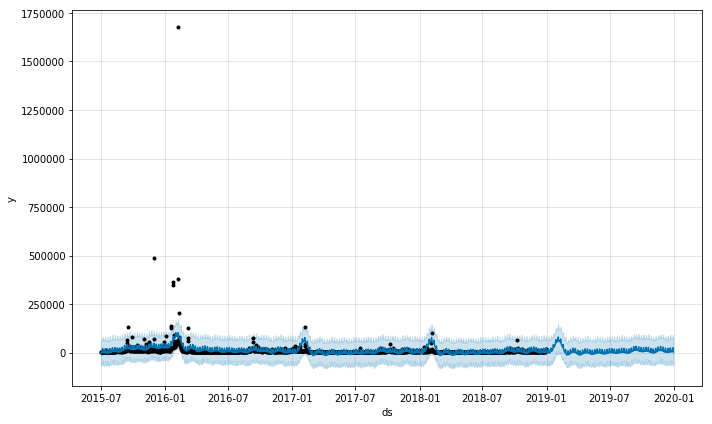

In [12]:
plt_forecast = m.plot(forecast)

(-170611.15620772587, 1765592.2455337013)
(735697.5020833333, 737506.95625)


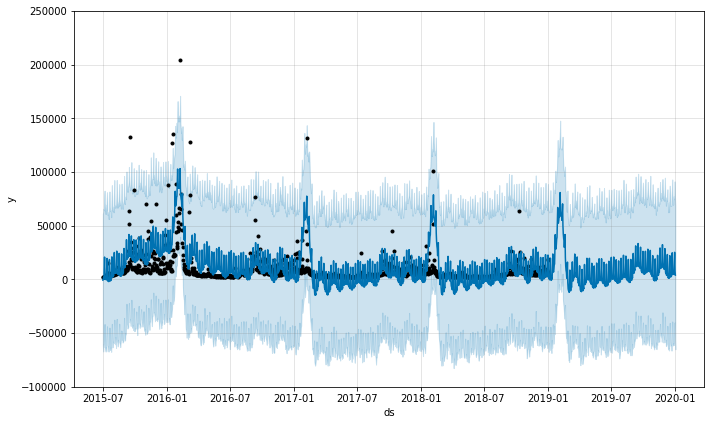

In [13]:
axes = plt_forecast.gca()
print(axes.get_ylim())
print(axes.get_xlim())
axes.set_ylim([-100000,250000])
plt_forecast

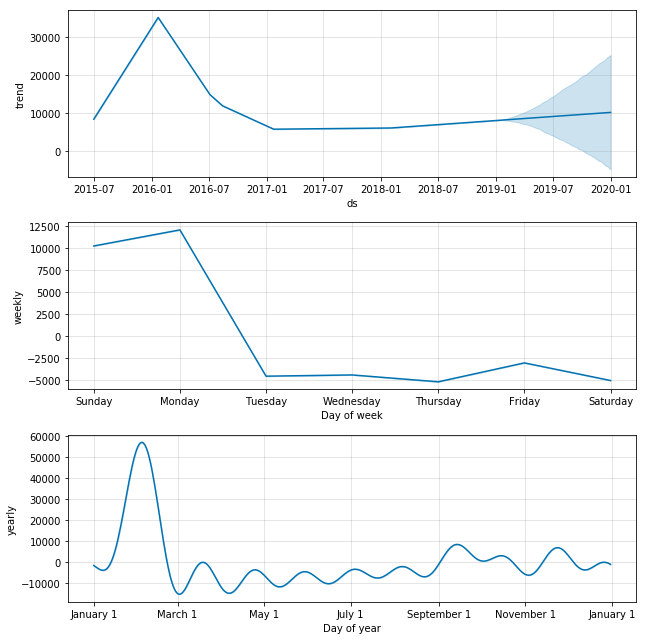

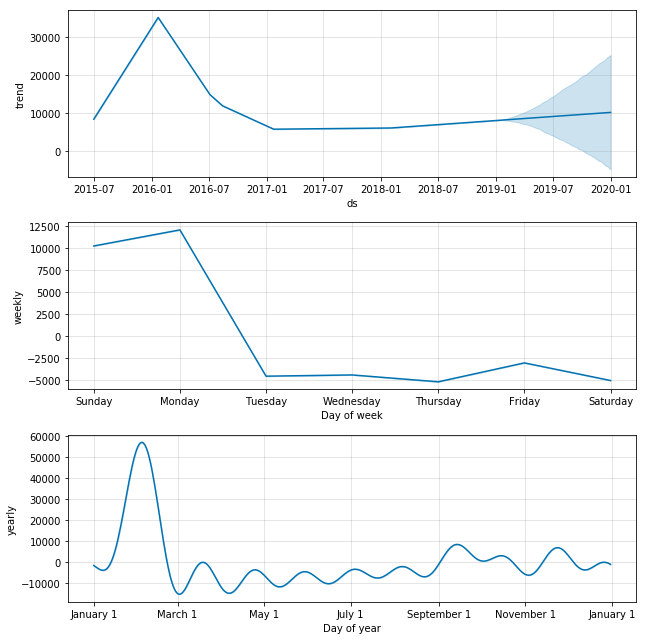

In [14]:
plt_components = m.plot_components(forecast)
plt_components

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


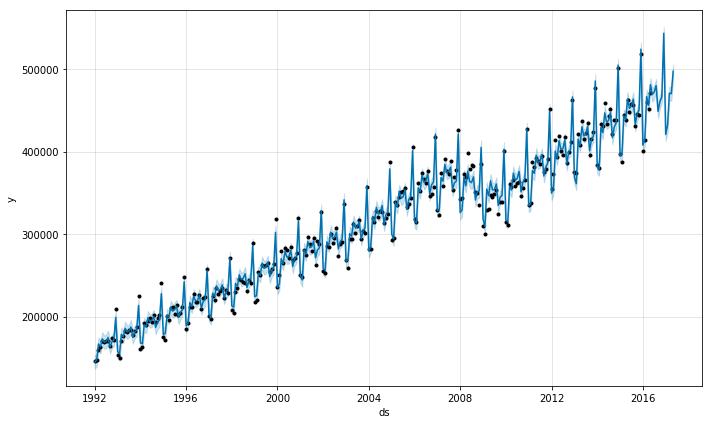

In [15]:
# example dataset with only monthly data
pdf = pd.read_csv('example_retail_sales.csv')
m = Prophet(seasonality_mode='multiplicative').fit(pdf)

future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig = m.plot(fcst)